# REDUCCION DE DIMENSIONALIDAD

Muchos de los problemas de Machine Learning implican miles e incluso millones de características por cada instancia de entrenamiento. Esto no solo hace que el entrenamiento sea extremadamente lento sino que, como veremos, también puede hacer mucho más difícil encontrar una buena solución. A menudo este problema es referido como la *maldición de la dimensionalidad*.

Afortunadamente, en los problemas del mundo real, a menudo es posible reducir considerablemente el número de características, convirtiendo un problema intratable en uno manejable. Por ejemplo, consideremos las imágenes MNIST (que vimos en el capítulo 3): los píxeles de los bordes de la imagen son casi siempre blancos, por lo que podríamos eliminarlos completamente del conjunto de entrenamiento sin perder mucha información. La siguiente figura ya nos confirmó que dichos píxeles no son importantes en absoluto para la tarea de clasificación. Además, dos píxeles vecinos a menudo están altamente correlacionados: si los combinamos en un único píxel (por ejemplo, tomando la media de las intensidades de los dos píxeles) no perderemos mucha información.

![mnist_pixel_importance](images/ch07/mnist_pixel_importance.png)

---

La reducción de la dimensionalidad pierde algo de información (al igual que comprimir una imagen a JPEG puede degradar su calidad), por lo que, aunque acelerará el entrenamiento, también puede hacer que nuestro sistema se ejecute peor. También hace nuestros pipelines un poco más complejos y, por tanto, difíciles de mantener. Por lo tanto, primero deberíamos intentar entrenar nuestro sistema con los datos originales antes de considerar el uso de la reducción de la dimensionalidad si el entrenamiento es demasiado lento. En algunos casos, sin embargo, reducir la dimensionalidad de los datos de entrenamiento pueden filtrar algún ruido y detalles innecesarios y, por tanto, resultar en una mayor ejecución (pero en general no es así, solo acelerará el entrenamiento).

---

Además de acelerar el entrenamiento, la reducción de dimensionalidad también es extremadamente útil para la visualización de datos (o *DataViz*). Reducir el número de dimensiones a dos (o tres) hace posible elaborar en un gráfico una vista condensada de un conjunto de entrenamiento de gran dimensionalidad y, a menudo, conseguir ideas importantes detectando patrones visualmente, tales como clusters. Además, DataViz es esencial para comunicar nuestras conclusiones a personas que no son científicos de datos, en particular responsables de tomar decisiones que usarán nuestros resultados.

En este capítulo discutiremos la maldición de la dimensionalidad y tendremos una idea de lo que sucede en el espacio de alta dimensionalidad. Después, presentaremos los dos principales enfoques de la reducción de dimensionalidad (proyección y Manifold Learning) e iremos a través de las tres técnicas más populares de reducción de dimensionalidad: PCA, Kernel PCA y LLE.

# La maldición de la dimensionalidad

Estamos tan acostumbrados a vivir en tres dimensiones (bueno, cuatro dimensiones si contamos el tiempo y algunas más si eres un teórico de cuerdas), que nuestra intuición nos falla cuando intentamos imaginar un espacio de alta dimensionalidad. Incluso un básico hipercubo 4D es increiblemente difícil de dibujar en nuestra mente (veamos la siguiente figura), mucho menos un elipsoide 200D doblado en un espacio 100D.

***Punto, segmento, cuadrado, cubo y [tesseract](https://homl.info/30) (hipercubos 0D a 4D)***

![hypercube](images/ch08/hypercube.png)

Resulta que muchas cosas se comportan muy diferentemente en un espacio de alta dimensionalidad. Por ejemplo, si seleccionamos un punto aleatorio en un cuadrado unitario (un cuadrado 1 x 1), tendremos solo una probabilidad del 0,4% de que esté localizado a 0.001 de un borde (en otras palabras, es muy improbable que un punto aleatorio sea "extremo" a lo largo de cualquier dimensión). Pero en un hipercubo unitario 10.000D (un cubo de 1 x 1 x ... 1, con diezmil unos), esta probabilidad es mayor que 99,999999%. La mayoría de los puntos en un hipercubo de alta dimensión están muy cerca del borde. *Dato curioso: cualquier persona que conozca es probablemente extremista en al menos una dimensión (por ejemplo, la cantidad de azúcar que ponen en su café), si se consideran suficientes dimensiones.*

Aquí hay una diferencia más problemática: si seleccionamos aleatoriamente dos puntos en un cuadrado unitario, la distancia entre ambos puntos será, de media, alrededor de 0,52. Si seleccionamos aleatoriamente dos puntos en un cubo unitario 3D, la distancia media será aproximadamente 0,66. Pero ¿qué pasa si seleccionamos aleatoriamente dos puntos en un hipercubo 1.000.000D? Bueno, lo creas o no, será alrededor de 408,25 (aproximadamente $\sqrt{\frac{1.000.000}{6}}$). Esto es bastante contraintuitivo: ¿cómo pueden estar dos puntos tan separados cuando están dentro del mismo hipercubo unitario? Este hecho implica que los datasets de alta dimensionalidad corren el riesgo de ser muy dispersos: la mayoría de las instancias de entrenamiento estarán probablemente muy lejos las unas de las otras. Por supuesto, esto también significa que una nueva instancia estará probablemente lejos de cualquier instancia de entrenamiento, lo que hace que las predicciones sean mucho menos confiables que en menores dimensiones, ya que se basarán en extrapolaciones mucho más grandes. En resumen, cuantas más dimensiones tenga el conjunto de entrenamiento, mayor será el riesgo de sobreajustarlo.

En teoría, una solución a la maldición de la dimensionalidad podría ser incrementar el tamaño del conjunto de entrenamiento para alcanzar una densidad suficiente de instancias de entrenamiento. Desafortunadamente, en la práctica el número de instancias requeridas para alcanzar una densidad dada crece exponencialmente con el número de dimensiones. Con solo 100 características (muchas menos que el problema MNIST), necesitaríamos más instancias de entrenamiento que átomos en el universo observable para que las instancias de entrenamiento estuvieran a una distancia unas de otras de 0,1 de media, asumiendo que se extendieran uniformemente a través de todas las dimensiones.

# Principales enfoques de la Reducción de Dimensionalidad

Antes de sumergirnos en los algoritmos específicos de reducción de la dimensionalidad, echemos un vistazo a los dos principales enfoques: proyección y Manifold Learning.

## Proyección

En la mayoría de los problemas del mundo real, las instancias de entrenamiento no se distribuyen de manera uniforme a través de todas las dimensiones. Muchas características son casi constantes, mientras que otras están altamente correlacionadas (como se discutió anteriormente para MNIST). Como resultado, todas las instancias de entrenamiento se encuentran realmente dentro (o cerca) de un *subespacio* de dimensiones mucho más bajas del espacio de alta dimensionalidad. Esto suena muy abstracto, así que veamos un ejemplo. En la siguiente figura podemos ver un dataset 3D representado por los círculos.

![dataset_3d_plot](images/ch08/dataset_3d_plot.png)

Observemos que todas las instancias de entrenamiento se encuentran cerca de un plano: este es un subespacio de menor dimensión (2D) del espacio de alta dimensión (3D). Ahora si proyectamos cada instancia de entrenamiento perpendicularmente en este subespacio (como se representa por las líneas cortas conectando las instancias al plano), obtenemos el nuevo dataset 2D mostrado en la siguiente figura. ¡Tachán! Acabamos de reducir la dimensión del dataset de 3D a 2D. Observemos que los ejes corresponden a nuevas características $z_1$ y $z_2$ (las coordenadas de las proyecciones en el plano).

![projection_2d](images/ch08/projection_2d.png)

Sin embargo, las proyecciones no siempre son la mejor aproximación a la reducción de la dimensionalidad. En muchos casos el subespacio puede girar y voltear, como el famoso dataset de juguete *rollo suizo* representado en la siguiente figura.

![swiss_roll](images/ch08/swiss_roll.png)

Simplemente proyectar en un plano (por ejemplo, eliminando $x_3$) aplastaría diferentes capas del rollo suizo, como se muestra a la izquierda de la siguiente figura. Sin embargo, lo que realmente deseamos es desenrollar el rollo suizo para obtener el conjunto de datos 2D a la derecha de la figura.

![unrolling_roll](images/ch08/unrolling_roll.png)

## Manifold Learning

Este rollo suizo es un ejemplo de *manifold* 2D. En pocas palabras, un manifold 2D es una forma 2D que puede ser doblada y girada en un espacio de alta dimensión. Más generalmente, un manifold *d*-dimensional es una parte de un espacio *n*-dimensional (donde *d* < *n*) que localmente se asemeja a un hiperplano *d*-dimensional. En el caso del rollo suizo, *d* = 2 y *n* = 3: localmente se asemeja a un plano 2D, pero está enrollado en tres dimensiones.

La mayoría de los algoritmos de reducción de dimensionalidad trabajan modelando el *manifold* en el cual se encuentran las instancias de entrenamiento; esto se denomina *Manifold Learning*. Se basa en la *asunción manifold*, también denominada la *hipótesis manifold*, que mantiene que la mayoría de los datasets del mundo real de alta dimensión se encuentran cerca de un manifold de dimensión mucho más baja. Esta suposición se observa muy a menudo empíricamente.

Una vez más pensemos en el dataset MNIST: todas las imágenes de dígitos escritos a mano tienen alguna similitud. Están hechas de líneas conectadas, los bordes son blancos y están más o menos centrados, etc. Si generamos aleatoriamente imágenes, solo una fracción ridículamente pequeña de ellas se parecería a dígitos escritos a mano. En otras palabras, los grados de libertad disponibles que tenemos si intentamos crear una imagen de un dígito es dramáticamente menor que los grados de libertad que tenemos si nos permitieran generar cualquier imagen que queramos. Estas restricciones tienen a apretar el dataset en un manifold de dimensiones bajas.

La asunción del manifold a menudo es acompañada por otra asunción implícita: que la tarea en cuestión (por ejemplo, clasificación o regresión) será más simple si se expresa en el espacio de menor dimensión del manifold. Por ejemplo, en la fila de arriba de la siguiente figura el rollo suizo está divido en dos clases: en el espacio 3D (a la izquierda), el limite de decisión sería bastante complejo, pero en el manifold desenrrollado en el espacio 2D (a la derecha), el límite de decisión es una simple línea recta.

![manifold_decision_boundary](images/ch08/manifold_decision_boundary.png)

Sin embargo, esta asunción no siempre es válida. Por ejemplo, en la fila inferior el límite de decisión está localizado en $x_1 = 5$. Este límite de decisión parece muy simple en el espacio 3D (un plano vertical), pero parece más complejo en el manifold desenrrollado (una colección de cuatro segmentos de línea independientes).

En resumen, si reducimos la dimensionalidad de nuestro conjunto de entrenamiento antes de entrenar un modelo, generalmente aceleraremos su entrenamiento, pero puede que no siempre nos conduzca a una mejor o más simple solución; depende del dataset.

Esperemos que ahora tengas una buena idea de qué es la maldición de la dimensionalidad y cómo los algoritmos de reducción de la dimensionalidad pueden combatirla, especialmente cuando se cumple la asunción de manifold. En el resto de este capítulo recorreremos algunos de los más populares algoritmos.

Veamos cómo hemos contruido las gráficas anteriores:

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
# Contruimos el dataset 3D

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

PCA usando descomposición SVD

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [8]:
X2D_using_svd = X2D

Con Scikit-Learn, PCA es realmente trivial. Incluso se preocupa de centrar la media por nosotros:

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [10]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [11]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Tengamos en cuenta que ejecutar PCA varias veces en conjuntos de datos ligeramente diferentes puede dar como resultado resultados diferentes. En general, la única diferencia es que algunos ejes pueden voltearse. En este ejemplo, PCA que usa Scikit-Learn ofrece la misma proyección que la que ofrece el enfoque SVD, excepto que ambos ejes están invertidos:

In [12]:
np.allclose(X2D, -X2D_using_svd)

True

Recupera los puntos 3D proyectados en el plano (subespacio 2D PCA)

In [13]:
X3D_inv = pca.inverse_transform(X2D)

Por supuesto, hubo cierta pérdida de información durante el paso de proyección, por lo que los puntos 3D recuperados no son exactamente iguales a los puntos 3D originales:

In [14]:
np.allclose(X3D_inv, X)

False

Calculamos el error de reconstrucción:

In [15]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

La transformación inversa en el enfoque SVD se ve así:

In [16]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

Las reconstrucciones de ambos métodos no son idénticas porque la clase `PCA` de Scikit-Learn se encarga automáticamente de revertir el centrado medio, pero si restamos la media, obtenemos la misma reconstrucción:

In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

El objeto `PCA` da acceso a los componentes principales que calculó:

In [18]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Comparemos con los primeros dos componentes principales calculados usando el método SVD:

In [19]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Observe cómo se voltean los ejes.

Ahora veamos el ratio de varianza explicada:

In [20]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

La primera dimensión explica el 84.2% de la varianza, mientras que la segunda explica el 14.6%.

Al proyectar hacia abajo a 2D, perdimos alrededor del 1.1% de la varianza:

In [21]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Aquí se explica cómo calcular el ratio de varianza explicada utilizando el enfoque SVD (recuerda que `s` es la diagonal de la matriz `S`):

In [22]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

A continuación, ¡generemos algunas figuras bonitas!

Clase de utilidad para dibujar flechas 3D (copiado de http://stackoverflow.com/questions/11140163)

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Expresemos el plano como una función de x e y.

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Dibujemos el conjunto de datos 3D, el plano y las proyecciones en ese plano.

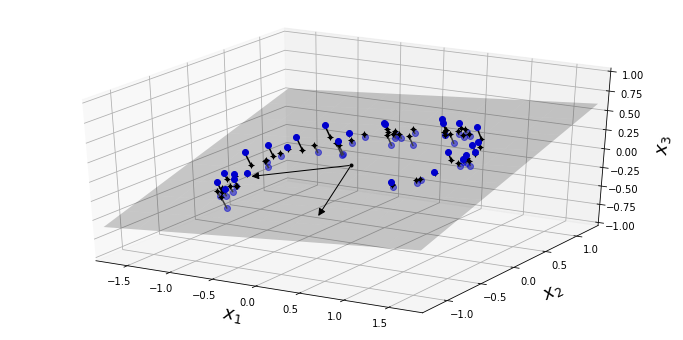

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

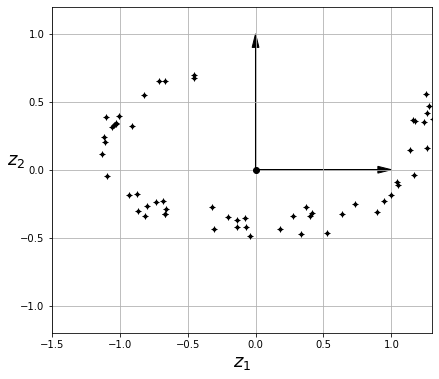

In [26]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True);

Rollo suizo

In [27]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

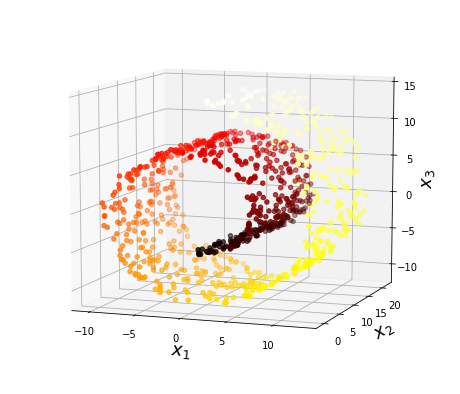

In [28]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

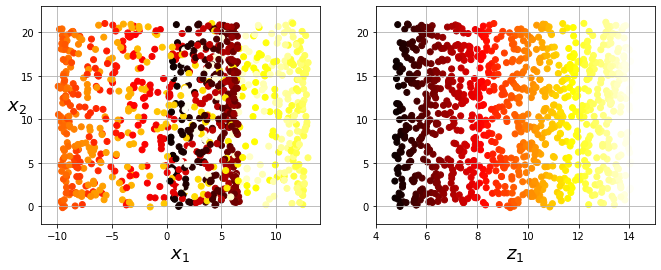

In [29]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

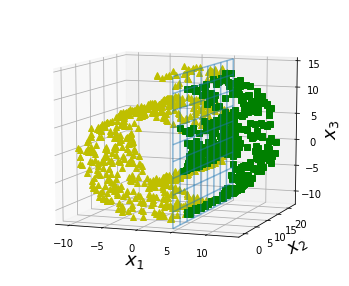

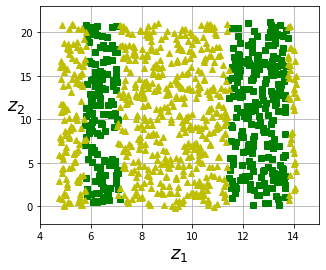

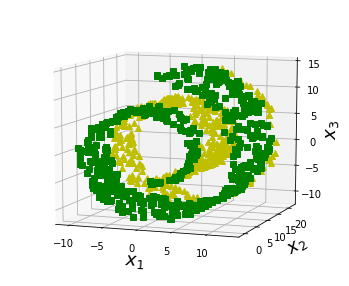

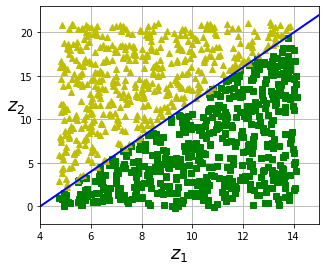

In [30]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

# PCA

El *Análisis de Componentes Principales* (PCA) es, con mucho, el algoritmo más popular de reducción de dimensionalidad. Primero identifica el hiperplano que se encuentra más cerca de los datos y después proyecta los datos en él.

## Preservando la varianza

Antes de que podamos proyectar los datos de entrenamiento en un hiperplano de menor dimensión, necesitamos elegir primero el hiperplano correcto. Por ejemplo, en la siguiente figura se representa un dataset 2D simple, junto con tres ejes diferentes (es decir, hiperplanos unidimensionales). A la derecha está el resultado de la proyección del dataset en cada uno de esos ejes. Como podemos ver, la proyección en la línea continua preserva la máxima varianza, mientras que la proyección en la línea de puntos conserva muy poca varianza y la proyección en la línea discontinua preserva una cantidad intermedia de varianza.

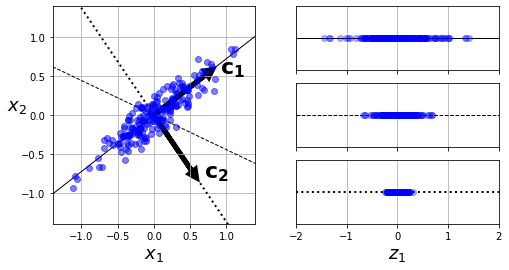

In [31]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

Parece razonable seleccionar el eje que preserva la máxima cantidad de varianza, ya que probablemente perderá menos información que otras proyecciones. Otra forma de justificar esta elección es que es el eje que minimiza la distancia cuadrática media entre el dataset original y su proyección en ese eje. Esta es la idea bastante simple que hay detrás de [PCA](https://homl.info/31).

## Componentes Principales

PCA identifica el eje que reporta la mayor cantidad de varianza en el conjunto de entrenamiento. En la figura anterior se trata de la línea continua. También encuentra un segundo eje, ortogonal al primero, que reporta la mayor cantidad de varianza restante. En este ejemplo 2D no hay elección: es la línea punteada. Si se tratara de un dataset de alta dimensión, PCA también encontraría un tercer eje, ortogonal a ambos ejes anteriores, y un cuarto, un quinto, y así sucesivamente, tantos ejes como número de dimensiones del dataset.

El vector unitario que define el $i^{esimo}$ eje se denomina el *componente principal* (PC) $i^{esimo}$. En la anterior figura que mencionábamos, el $1^{er}$ PC es **$c_1$**, el 2º PC es **$c_2$**. y en la figura siguiente que ya vimos, las dos primeras PC están representadas por las flechas ortogonales en el plano, y la tercera PC sería ortogonal al plano (apuntando hacia arriba o hacia abajo).

![dataset_3d_plot](images/ch08/dataset_3d_plot.png)

---

La dirección de los componentes principales no es estable: si perturbamos ligeramente el conjunto de entrenamiento y ejecutamos de nuevo PCA, algunos de los nuevos PCA pueden apuntar en la dirección contraria a los PCs originales. Sin embargo, generalmente seguirán en el mismo eje. En algunos casos, una par de PCs pueden rotar o intercambiarse, pero el plano que definen generalmente seguirá siendo el mismo.

---

Entonces, ¿cómo encontrar los componentes principales en un conjunto de entrenamiento? Afortunadamente, existe una técnica estándar de factorización de matriz llamada *Descomposición de Valor Singular* (SVD - *Singular Value Decomposition*) que puede descomponer la matrix **X** del conjunto de entrenamiento en la matriz multiplicación de tres matrices $U \sum V^T$, donde **V** contiene todos los componentes principales que estamos buscando, como se muestra en la siguiente ecuación.

***Matriz de componentes principales***

![PC_matrix](images/ch08/PC_matrix.png)

El siguiente código Python usa la función `svd()` de NumPy para obtener todos los componentes principales del conjunto de entrenamiento y luego extraer los primeros dos PCs:

In [32]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

---

PCA asume que el dataset está centrado alrededor del origen. Como veremos, las clases PCA de Scikit-Learn se encargan de centrar los datos por nosotros. Sin embargo, si implementamos PCA por nosotros mismos (como en el ejemplo anterior), o si usamos otras librerías, no debemos olvidar centrar primero los datos.

---

## Proyectando hacia *d* Dimensiones

Una vez que hemos identificado todos los componentes principales, podemos reducir la dimensión del dataset  bajando a *d* dimensiones proyectándolo en el hiperplano definido por los primeros *d* componentes principales. Seleccionar este hiperplano asegura que la proyección preservará tanta varianza como sea posible. Por ejemplo, en la figura anterior el dataset 3D es proyectado hacia abajo al plano 2D definido por los primeros dos principales componentes, preservando una gran parte de la varianza del dataset. Como resultado, la proyección 2D se parece mucho al dataset 3D original.

Para proyectar el conjunto de entrenamiento en el hiperplano, simplemente podemos calcular la matriz multiplicación de la matriz **X** del conjunto de entrenamiento por la matriz **W**$_d$, definida como la matriz que contiene los primeros *d* componentes principales (es decir, la matriz compuesta de las primeras *d* columnas de **V**), como se muestra en la siguiente ecuación.

***Proyectar hacia abajo el conjunto de entrenamiento a d dimensiones***

**X**$_{d-proy}$ = **XW**$_d$

El siguiente código Python proyecta el conjunto de entrenamiento en el plano definido por los primeros dos componentes principales:

In [33]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

¡Ahí lo tenemos! Ya sabemos cómo reducir la dimensión de cualquier dataset a cualquier número de dimensiones hacia abajo, mientras preservamos la mayor varianza posible.

## Usando Scikit-Learn

La clase PCA de Scikit-Learn implementa PCA usando descomposición SVD como ya vimos anteriormente. El código siguiente aplica PCA para reducir la dimensión del dataset a dos dimensiones (tengamos en cuenta que se encarga automáticamente de centrar los datos):

In [34]:
# Contruimos el dataset 3D

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

Después de entrenar el transformador PCA en el dataset podemos acceder a los componentes principales usandor la variable `components_` (tengamos en cuenta que contiene los PCs como vectores horizontales, así, por ejemplo, el primer componente principal es igual a `pca.components_.T[:, 0]`)

## Ratio de varianza explicada

Otra información muy útil es el *ratio de varianza explicada* de cada componente principal, disponible a través de la variable `explained_variance_ratio`. Indica la proporción de la varianza del dataset que se encuentra a lo largo del eje de cada componente principal. Por ejemplo, veamos los ratios de varianza explicada de los primeros dos componentes principales del dataset 3D representando en la figura anterior:

In [36]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

Esto nos dice que el 84,2% de la varianza del dataset se encuentra a lo largo del primer eje y que el 14,6% se encuentra a lo largo del segundo eje. Esto deja menos del 1,2% para el tercer eje, por lo que es razonable asumir que contenga poca información.

## Elegir el número correcto de dimensiones

En lugar de elegir arbitrariamente el número de dimensiones a reducir, normalmente es preferible elegir el número de dimensiones que se necesitan para obtener una porción suficientemente grande de varianza (por ejemplo, 95%). A menos, por supuesto, que estemos reduciendo dimensiones para visualización de datos -en cuyo caso, normalmente, querremos reducir la dimensión a 2 ó 3.

El siguiente código calcula PCA sin reducir la dimensión, luego calcula el número mínimo de dimensiones requeridas para preservar el 95% de la varianza del conjunto de entrenamiento:

In [37]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [38]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

Luego podemos establecer `n_components=d` y ejecutar PCA de nuevo. Sin embargo, existe una opción mejor: en lugar de especificar el número de componentes principales que queremos preservar, podemos establecer que `n_components` sea un float entre `0.0` y `1.0`, indicando el ratio de varianza que queremos preservar:

In [42]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

np.sum(pca.explained_variance_ratio_)

0.9503684424557436

Otra opción más es dibujar la varianza explicada como una función del número de dimensiones (simplemente dibujando `cumsum`; ver la siguiente figura). Por lo general, habrá un codo en la curva, donde la varianza explicada dejará de crecer rápidamente. Podemos pensar en esto como la dimensión intrínseca del dataset. En este caso, podemos ver que reducir la dimensión hasta aproximadamente 100 dimensiones no perdería demasiada varianza explicada.

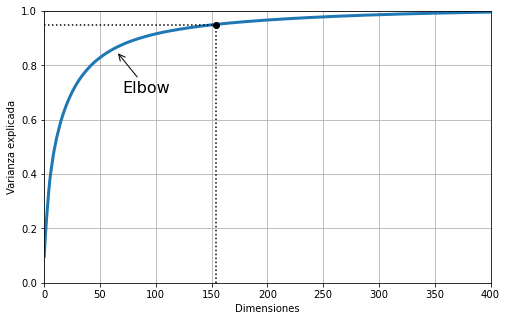

In [45]:
plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensiones")
plt.ylabel("Varianza explicada")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

## PCA para compresión

Obviamente, después de reducir la dimensión el conjunto de entrenamiento ocupa mucho menos espacio. Por ejemplo, intentemos aplicar PCA al dataset MNIST mientras preservamos el 95% de su varianza. Deberíamos encontrar que cada instancia tendrá poco más de 150 características, en lugar de las 784 originales. Entonces, aunque se conserva la mayoría de la varianza, ¡ahora el dataset es menos del 20% de su tamaño original! Esto es un ratio de compresión razonable y podemos ver cómo esto acelera tremendamente un algoritmo de clasificación (por ejemplo un clasificador SVM)

También es posible descomprimir el dataset reducido para volver a las 784 dimensiones aplicando la transformación inversa de la proyección de PCA. Por supuesto esto no nos devolverá los datos originales, dado que la proyección perdió un poco de información (dentro del 5% de la varianza que se eliminó), pero es probable que esté bastance cerca de los datos originales. La distancia cuadrática media entre los datos originales y los datos reconstruidos (comprimidos y después descomprimidos) se denomina *error de reconstrucción*. Por ejemplo, el código siguiente comprime el dataset MNIST a 154 dimensiones, después usa el método `inverse_transform()` para descomprimirlo y volver a las 784 dimensiones. La siguiente figura muestra algunos dígitos del conjunto de entrenamiento original (a la izquierda) y los correspondientes dígitos después de la compresión y descompresión. Podemos ver que existe una ligera pérdida de calidad de imagen, pero los dígitos están casi intactos.

In [46]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [47]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

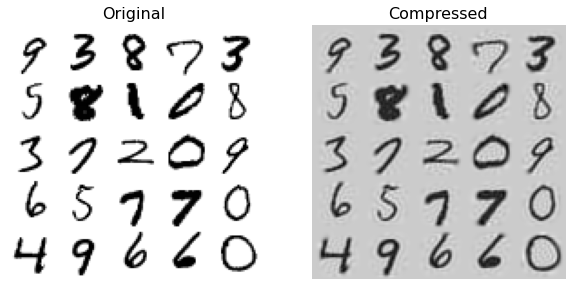

In [52]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)